In [1]:
# Mount Google Drive to access the dataset folder
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Set the path to the folder containing the datasets
folder_path = '/content/drive/MyDrive/DSA2025Spring/TermProjectDatas/'

Mounted at /content/drive


In [2]:
# Load and clean space debris data
space_debris_data = pd.read_csv(folder_path + 'SpaceDebrisStats.csv', sep=';')
space_debris_data.columns = space_debris_data.columns.str.strip()
space_debris_data = space_debris_data.rename(columns={
    'Space Debris Contributor': 'Country',
    '# of Space Debris': 'Debris'
})

space_debris_df = space_debris_data

space_debris_df.head()

,Country,Debris
0,Russian Federation,4521
1,United States,4317
2,China,4137
3,France,370
4,India,62


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.read_csv(folder_path + 'low-earth-orbits-objects.csv')

# Filter only Debris entries from 1996 onwards
df_debris = df[(df['Entity'] == 'Debris') & (df['Year'] >= 1996)].copy()

In [4]:
import numpy as np
import pandas as pd
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

# ——— Prepare training and forecast data ———
# Assume df_debris is already defined (filtered 'Debris' entries)

# 1) Use only post-1996 data for training
df_post = df_debris[df_debris['Year'] >= 1999].copy()
X_train = df_post[['Year']].values
y_train = df_post['Number of tracked objects in lower Earth orbit'].values

# 2) Define future years 2025–2034 for forecasting
future_years = np.arange(2025, 2035).reshape(-1, 1)

# ——— Define models to evaluate ———
models = {
    'KNN (k=3)':            KNeighborsRegressor(n_neighbors=3),
    'Linear Regression':    LinearRegression(),
    'SVR':                  SVR(),
    'Random Forest':        RandomForestRegressor(n_estimators=100, random_state=42),
    'Neural Network (MLP)': MLPRegressor(hidden_layer_sizes=(50,), max_iter=5000, random_state=42)
}

# ——— 1) Train each model and compute R² on training set ———
r2_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    r2_results.append({'Model': name, 'R2': round(model.score(X_train, y_train), 4)})

df_r2 = pd.DataFrame(r2_results)
print("=== R² Scores (post-1999 training) ===")
print(df_r2)

# ——— 2) Forecast 2025–2034 for each model ———
df_forecasts = pd.DataFrame({'Year': future_years.flatten()})
for name, model in models.items():
    preds = model.predict(future_years)
    df_forecasts[name] = np.round(preds).astype(int)

print("\n=== Forecasts 2025–2034 ===")
print(df_forecasts)

=== R² Scores (post-1999 training) ===
                  Model      R2
0             KNN (k=3)  0.9766
1     Linear Regression  0.6599
2                   SVR -0.1819
3         Random Forest  0.9936
4  Neural Network (MLP) -0.0920

=== Forecasts 2025–2034 ===
   Year  KNN (k=3)  Linear Regression    SVR  Random Forest  \
0  2025      12930              13844  15834          12627   
1  2026      12930              13731  15835          12627   
2  2027      12930              13617  15835          12627   
3  2028      12930              13503  15836          12627   
4  2029      12930              13389  15837          12627   
5  2030      12930              13276  15838          12627   
6  2031      12930              13162  15838          12627   
7  2032      12930              13048  15839          12627   
8  2033      12930              12934  15839          12627   
9  2034      12930              12821  15839          12627   

   Neural Network (MLP)  
0                 15

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# ——— Assume df_debris is already defined as:
# df_debris = df[df['Entity']=='Debris']

# Prepare full Year/X and target y
X = df_debris[['Year']].values
y = df_debris['Number of tracked objects in lower Earth orbit'].values

# Define forecast years 2025–2034
future_years = np.arange(2025, 2035).reshape(-1, 1)

# ——— 1) Polynomial Regression (degree=3) ———
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly       = poly.fit_transform(X)
Xf_poly      = poly.transform(future_years)

model_poly = LinearRegression().fit(X_poly, y)
pred_poly  = model_poly.predict(Xf_poly)

df_poly_forecast = pd.DataFrame({
    'Year': future_years.flatten(),
    'Poly3 Predicted Debris': np.round(pred_poly).astype(int)
})

# ——— 2) Piecewise Linear Regression (break at 1996) ———
break_year = 1999
X_knot     = np.maximum(0, X - break_year)
X_pw       = np.hstack([X, X_knot])

model_pw = LinearRegression().fit(X_pw, y)

# construct future piecewise features
Xf_knot  = np.maximum(0, future_years - break_year)
Xf_pw    = np.hstack([future_years, Xf_knot])
pred_pw  = model_pw.predict(Xf_pw)

df_pw_forecast = pd.DataFrame({
    'Year': future_years.flatten(),
    'Piecewise Predicted Debris': np.round(pred_pw).astype(int)
})

# ——— Display or return both forecasts ———
print("Polynomial Regression Forecast (2025–2034)")
print(df_poly_forecast.to_string(index=False))

print("\nPiecewise Regression Forecast (2025–2034)")
print(df_pw_forecast.to_string(index=False))


Polynomial Regression Forecast (2025–2034)
 Year  Poly3 Predicted Debris
 2025                   13049
 2026                   12935
 2027                   12863
 2028                   12837
 2029                   12864
 2030                   12947
 2031                   13092
 2032                   13304
 2033                   13588
 2034                   13948

Piecewise Regression Forecast (2025–2034)
 Year  Piecewise Predicted Debris
 2025                       13981
 2026                       13882
 2027                       13784
 2028                       13685
 2029                       13587
 2030                       13488
 2031                       13389
 2032                       13291
 2033                       13192
 2034                       13094


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assume df_debris is already defined:
# df_debris = df[df['Entity']=='Debris']

# Prepare features & target
X = df_debris[['Year']].values
y = df_debris['Number of tracked objects in lower Earth orbit'].values

# 1) Polynomial Regression (degree=3)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)
r2_poly = model_poly.score(X_poly, y)

# 2) Piecewise Linear Regression (break at 1996)
break_year = 1999
X_knot = np.maximum(0, X - break_year)
X_pw   = np.hstack([X, X_knot])
model_pw = LinearRegression().fit(X_pw, y)
r2_pw   = model_pw.score(X_pw, y)

# Print results
print(f"R² (Polynomial degree=3): {r2_poly:.4f}")
print(f"R² (Piecewise at {break_year}): {r2_pw:.4f}")


R² (Polynomial degree=3): 0.7857
R² (Piecewise at 1999): 0.7007


In [14]:
# Check if 'df_stats' is already defined; if not, read it from the CSV file
if 'df_stats' not in globals():
    df_stats = pd.read_csv(folder_path + 'SpaceDebrisStats.csv', sep=';')

    # Rename columns for consistency
    df_stats.rename(columns={
        'Space Debris Contributor': 'Country',
        '# of Space Debris':        'CountryDebris'
    }, inplace=True)

    # Calculate each country's proportion of total space debris
    df_stats['Proportion'] = df_stats['CountryDebris'] / df_stats['CountryDebris'].sum()

# Get the column in the forecast DataFrame that holds the total debris count (excluding 'Year')
total_col = [c for c in df_poly_forecast.columns if c != 'Year'][0]

# Rename that column to 'TotalDebris' for clarity
df_total = df_poly_forecast.rename(columns={total_col: 'TotalDebris'})

# Initialize an empty list to store records for each country and year
records = []

# Iterate through each row in the total debris forecast
for _, tot in df_total.iterrows():
    year  = int(tot['Year'])
    total = tot['TotalDebris']

    # For each year, distribute the total debris count across countries based on proportions
    for _, st in df_stats.iterrows():
        records.append({
            'Year':        year,
            'Country':     st['Country'],
            'Debris Count': int(round(total * st['Proportion']))  # Proportional allocation
        })

# Create a DataFrame from the records and sort by country and year
df_country_forecast = (
    pd.DataFrame(records)
      .sort_values(['Country','Year'])
      .reset_index(drop=True)
)

# Display the final country-level forecasted debris data
df_country_forecast


,Year,Country,Debris Count
0,2025,Argentina,1
1,2026,Argentina,1
2,2027,Argentina,1
3,2028,Argentina,1
4,2029,Argentina,1
...,...,...,...
105,2030,United States,4137
106,2031,United States,4184
107,2032,United States,4251
108,2033,United States,4342


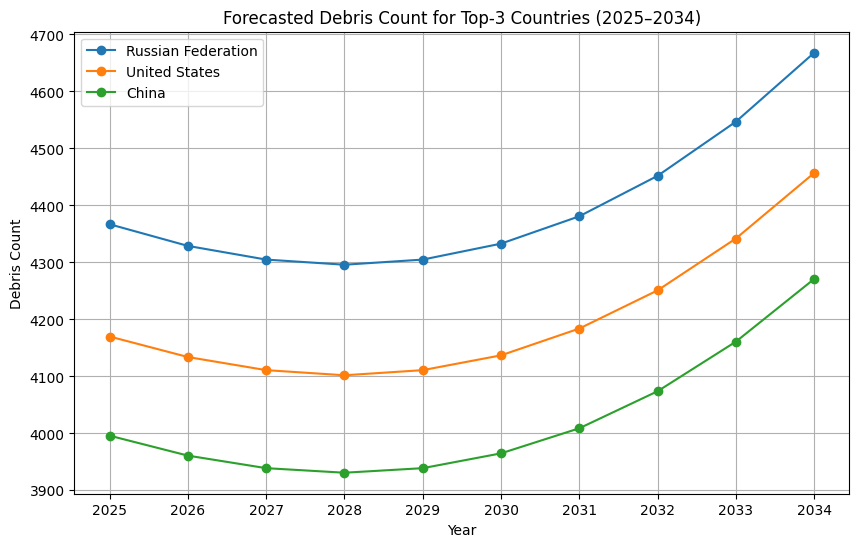

In [8]:
import matplotlib.pyplot as plt

# Identify top 3 countries by total predicted debris over the forecast period
top3 = (
    df_country_forecast
    .groupby('Country')['Debris Count']
    .sum()
    .nlargest(3)
    .index
)

# Plot lines with markers for each top-3 country on one figure
plt.figure(figsize=(10, 6))
years = sorted(df_country_forecast['Year'].unique())
plt.xticks(years)

for country in top3:
    df_sub = df_country_forecast[df_country_forecast['Country'] == country]
    plt.plot(
        df_sub['Year'],
        df_sub['Debris Count'],
        marker='o',        # marker at each data point
        linestyle='-',     # connect points with lines
        label=country      # legend label
    )

plt.xlabel('Year')
plt.ylabel('Debris Count')
plt.title('Forecasted Debris Count for Top-3 Countries (2025–2034)')
plt.legend()
plt.grid(True)
plt.show()


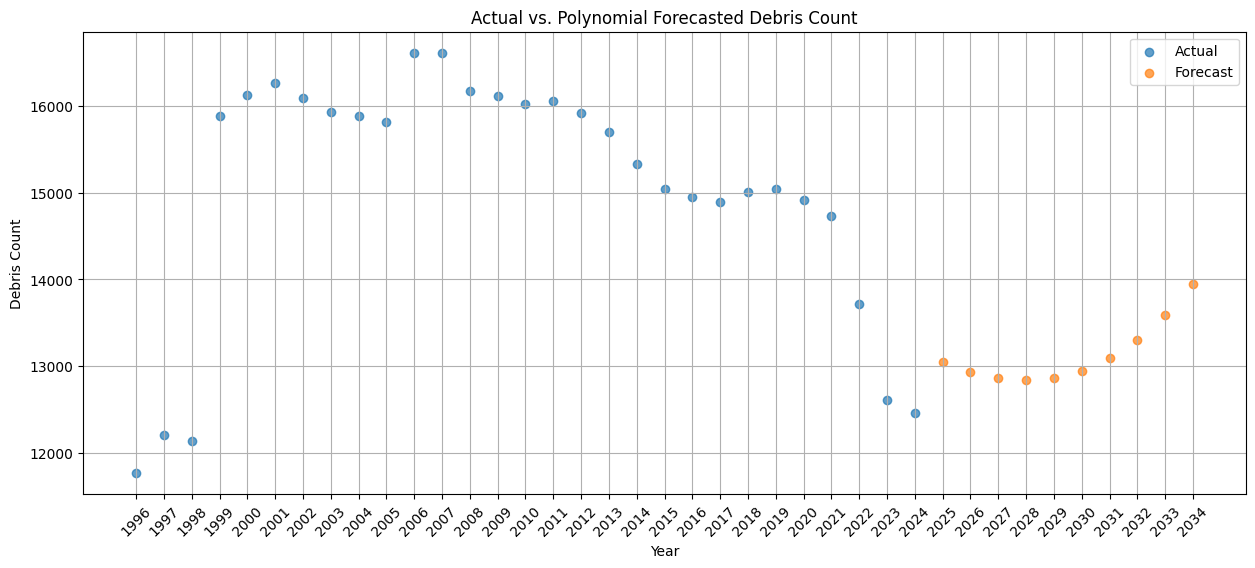

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 2) Prepare actual data up to 2024
actual = df_debris[['Year', 'Number of tracked objects in lower Earth orbit']].copy()
actual = actual.rename(columns={'Number of tracked objects in lower Earth orbit': 'Debris Count'})
actual['Type'] = 'Actual'

# 3) Recompute polynomial forecast if needed (or skip if df_poly_forecast already exists)
poly = PolynomialFeatures(degree=3, include_bias=False)
X = df_debris[['Year']].values
y = df_debris['Number of tracked objects in lower Earth orbit'].values
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)

future_years = np.arange(2025, 2035).reshape(-1, 1)
Xf_poly = poly.transform(future_years)
predicted = model_poly.predict(Xf_poly)

df_forecast = pd.DataFrame({
    'Year': future_years.flatten(),
    'Debris Count': np.round(predicted).astype(int)
})
df_forecast['Type'] = 'Forecast'

# 4) Combine and plot
combined = pd.concat([actual, df_forecast], ignore_index=True)

plt.figure(figsize=(15, 6))
for t, grp in combined.groupby('Type'):
    plt.scatter(grp['Year'], grp['Debris Count'], label=t, alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Debris Count')
plt.title('Actual vs. Polynomial Forecasted Debris Count')
plt.xticks(list(combined['Year'].unique()), rotation=45)
plt.legend()
plt.grid(True)
plt.show()


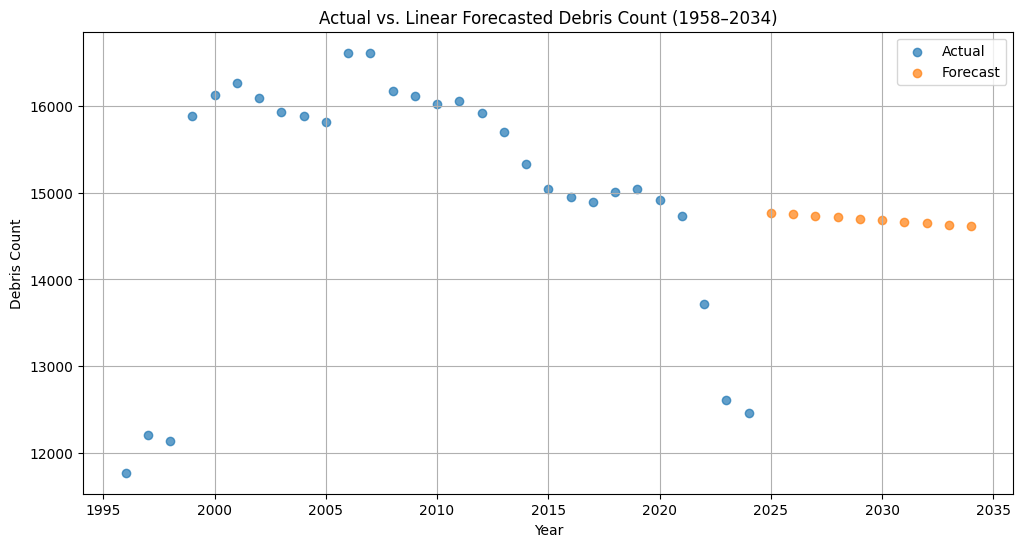

In [11]:
from sklearn.linear_model import LinearRegression

# Extracting the input feature (Year) and target variable (Number of tracked objects)
X = df_debris[['Year']].values
y = df_debris['Number of tracked objects in lower Earth orbit'].values

# Fitting a linear regression model to the data
lin_model = LinearRegression().fit(X, y)

# Creating a range of future years from 2025 to 2034 for prediction
future_years = np.arange(2025, 2035).reshape(-1, 1)

# Predicting debris count for the future years using the linear model
pred_linear = lin_model.predict(future_years)

# Creating a DataFrame for the forecasted debris counts
df_linear_forecast = pd.DataFrame({
    'Year': future_years.flatten(),
    'Debris Count': np.round(pred_linear).astype(int),
    'Type': 'Forecast'
})

# Preparing the actual data for visualization
df_actual = df_debris[['Year', 'Number of tracked objects in lower Earth orbit']].copy()
df_actual.columns = ['Year', 'Debris Count']
df_actual['Type'] = 'Actual'

# Combining actual and forecasted data into one DataFrame
df_combined_linear = pd.concat([df_actual, df_linear_forecast], ignore_index=True)

# Plotting actual vs. forecasted debris count
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for t, grp in df_combined_linear.groupby('Type'):
    plt.scatter(grp['Year'], grp['Debris Count'], label=t, alpha=0.7)
plt.title('Actual vs. Linear Forecasted Debris Count (1958–2034)')
plt.xlabel('Year')
plt.ylabel('Debris Count')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Initialize an empty list to store country-level forecasted records
records = []

# Iterate over each forecasted year and total debris count
for _, row in df_linear_forecast.iterrows():
    year = row['Year']
    total = row['Debris Count']

    # For each year, distribute the total debris count across countries based on their proportions
    for _, stat in df_stats.iterrows():
        records.append({
            'Year': year,
            'Country': stat['Country'],
            'Debris Count': int(round(total * stat['Proportion']))  # Allocate proportionate debris count
        })

# Convert the list of records into a DataFrame
df_country_linear = pd.DataFrame(records)

# Sort the data by country and year for better readability and analysis
df_country_linear_sorted = (
    df_country_linear
    .sort_values(['Country', 'Year'])
    .reset_index(drop=True)
)

# Display the sorted country-level forecasted data
df_country_linear_sorted


,Year,Country,Debris Count
0,2025,Argentina,1
1,2026,Argentina,1
2,2027,Argentina,1
3,2028,Argentina,1
4,2029,Argentina,1
...,...,...,...
105,2030,United States,4692
106,2031,United States,4686
107,2032,United States,4681
108,2033,United States,4675
